In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import transformers
import torch
from transformers import pipeline
import string
from transformers import BertTokenizer, BertForMaskedLM
import statistics
import keras
import re

from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer

from valuemap.models import Model, MultiModel
from valuemap.values import ValueMap, ValueSearch
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
# Import the human values from values.py labels
from valuemap.values import VALUE_LABELS

from sklearn.feature_extraction.text import CountVectorizer
from keras.utils import to_categorical
from bornrule import BornClassifier
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bornrule import BornClassifier

In [2]:
def load_dataset():
    # Load the arguments and labels into separate DataFrames
    df_arguments = pd.read_csv('arguments-validation.tsv', delimiter='\t')
    df_labels = pd.read_csv('labels-validation.tsv', delimiter='\t')

    # Merge the two DataFrames on the 'Argument ID' column
    df = pd.merge(df_arguments, df_labels, on='Argument ID')

    # Extract the argument text from each DataFrame
    id = df_arguments['Argument ID'].tolist()
    arguments = df_arguments['Premise'].tolist()
    stances = df_arguments['Stance'].tolist()
    conclusions = df_arguments['Conclusion'].tolist()

    return arguments, stances, conclusions, id, df

In [3]:
def get_all_human_values(df):
    # Initialize an empty dictionary to store the human values for each argument ID
    human_values_dict = {}

    # Iterate over all rows in the DataFrame
    for _, row in df.iterrows():
        # Get the argument ID
        argument_id = row['Argument ID']

        # Extract the human values
        values_dict = row.iloc[4:].to_dict()  # Adjust the column index as needed

        # Get a list of human values that have value 1
        human_values = [key.split(':')[0] for key, value in values_dict.items() if value == 1]

        # Convert the list to a set to remove duplicates, then convert it back to a list
        human_values = list(set(human_values))

        # Store the human values in the dictionary
        human_values_dict[argument_id] = human_values

    return human_values_dict

In [4]:
semeval_validation_set_results = get_all_human_values(load_dataset()[4])

In [5]:
semeval_validation_set_arguments = load_dataset()[0]

In [6]:
def process_sentences(sentences):
    processed = []
    for sentence in sentences:
        # Remove punctuation
        sentence = sentence.translate(str.maketrans('', '', string.punctuation))
        # Convert to lowercase
        sentence = sentence.lower()
        processed.append(sentence)
    return processed

In [7]:
# Load dataset
arguments, stances, conclusions, id, df = load_dataset()

# Preprocess premise and conclusion
arguments = process_sentences(arguments)
conclusions = process_sentences(conclusions)

In [8]:
# model inizialization
model_bert = pipeline('fill-mask', model='bert-base-uncased') # Bert

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
# model inizialization for adjectiveList-based approach
def load_model() :
    # Load the model and tokenizer
    model = BertForMaskedLM.from_pretrained('bert-base-uncased')
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    return model, tokenizer

model, tokenizer = load_model()[0], load_model()[1]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model t

In [10]:
def radial_plot(results):
    # Create a list of adjectives and their probabilities
    adjectives = list(results.keys())
    probabilities = list(results.values())

    # Compute angle for each adjective
    angles = np.linspace(0, 2 * np.pi, len(adjectives), endpoint=False).tolist()

    # The figure is plotted in a polar projection
    fig, ax = plt.subplots(figsize=(3, 3), subplot_kw=dict(polar=True))
    
    # Plot each line separately
    for i in range(len(adjectives)):
        ax.plot([angles[i], angles[i]], [0, probabilities[i]], color='blue')
    
    # Fill the area under the curve
    ax.fill(angles, probabilities, 'blue', alpha=0.1)
    
    # Set the yticks to be empty and xticks to be the adjectives
    ax.set_yticklabels([])
    ax.set_xticks(angles)
    ax.set_xticklabels(adjectives)
    
    # Display the plot
    plt.show()

In [11]:
def generate_prompt(stance, conclusion, argument):
    return f"i am {stance} the fact that {conclusion} because i think that {argument}. i am a {tokenizer.mask_token}."

In [12]:
en_path = 'C:/Users/ffraa/Desktop/Università/Tesi/vast-value-map-main/valuemap/Data/wiki.en.vec'
n_max = 100000
eng = Model(en_path, n_max=n_max)
oracle = MultiModel(eng=eng)
vocabulary_path = 'C:/Users/ffraa/Desktop/Università/Tesi/vast-value-map-main/valuemap/Refined_dictionary.txt'
value_map = ValueMap.from_vocabulary(vocabulary_path) 
value_oracle = ValueSearch(valuemap=value_map, oracle=oracle, k=10, depth=2)

In [13]:
# Load pretrained word2vec model
path = 'C:/Users/ffraa/Desktop/Università/Tesi/vast-value-map-main//valuemap/GoogleNews-vectors-negative300.bin'
similarity_model = KeyedVectors.load_word2vec_format(path, binary=True)

In [14]:
def sort_elements(element) :
    sorted_element = {k: v for k, v in sorted(element.items(), key=lambda item: item[1], reverse=True)}
    return sorted_element

In [15]:
def find_closest_word(word, dictionary, model):
    # Get the embedding for the predicted word
    word_embedding = model[word]
    max_similarity = -1
    closest_word = None
    # Iterate over all words in the dictionary
    for dict_word in dictionary.keys():
        try:
            # Get the embedding for the word from the dictionary
            dict_word_embedding = model[dict_word]

            # Calculate the cosine similarity between the two embeddings
            similarity = cosine_similarity([word_embedding], [dict_word_embedding])

            # If the similarity is higher than the current maximum, update the maximum
            if similarity > max_similarity:
                max_similarity = similarity
                closest_word = dict_word
        except KeyError:
            continue  # Continue if the word isn't into the model
    return closest_word

In [16]:
def calculate_oracle_answer(word):
    answers = value_oracle.search(word, lang='eng')
    aggregated = value_oracle.aggregated_search(word, lang='eng')
    
    if answers is not None:
        # Convert the aggregated values to a series and normalize them
        aggregated_series = pd.Series(aggregated).sort_values(ascending=False) / sum(aggregated.values())
        
        return answers, aggregated_series

    return None, None

In [17]:
def human_value_detection(word, dictionary, model, aggregated_values):
    
    try:
        # Calculate answers
        print(f"\n{word}")
        answers, aggregated = calculate_oracle_answer(word)
        
        if not answers :
            print(f"No values available for the word. Finding the closest word in the dictionary...")
            closest_word = find_closest_word(word, dictionary, model)
            print(f"The closest word in the dictionary for {word} is {closest_word}.")        
            # Closest word's answers
            answers, aggregated = calculate_oracle_answer(closest_word)
        # Print answers 
        sorted_answers = sorted(answers, key=lambda x: x['similarity'], reverse=True)
        for answer in sorted_answers:
            print(f"{answer}")

        # Add aggregate values
        for value, probability in aggregated.items():
            if value in aggregated_values:
                aggregated_values[value] += probability
            else:
                aggregated_values[value] = probability
    except KeyError as e:
        print(e)
    # Normalize aggregated values
    total_probability = sum(aggregated_values.values())
    normalized_values = {value: probability / total_probability for value, probability in aggregated_values.items()}
    
    return normalized_values

In [18]:
def generate_word(stance, conclusion, argument, model):
    # Initialize an empty list to store the results
    results = []

    # Create prompt 
    prompt = generate_prompt(stance, conclusion, argument)
    
    # Generate the filling
    output = model(prompt)
   
    # Sort output by 'score'
    output.sort(key=lambda x: x['score'], reverse=True)
    
    # Create a dictionary of other predicted words with their scores
    predictions = {result['token_str']: result['score'] for result in output}

    # Extract 'sequence' with higher 'score'
    description = output[0]['sequence']
    
    return predictions, description

In [19]:
adjective_list = [ 
    "conservative","republican","capitalist",
    "libertarian","centrist","democrat",
    "liberal","progressive","socialist",
    "communist","anarchist",
]

In [20]:
def generate_word_adj(stance, conclusion, argument, model, tokenizer, adjective_list):
    # Create prompt 
    prompt = generate_prompt(stance, conclusion, argument)
    
    # Initialize a dictionary to store the probabilities
    probabilities = {}
    # For each word in the list, generate a score
    for word in adjective_list:
        # Replace the mask token with the word
        new_prompt = prompt.replace(tokenizer.mask_token, word)
        # Encode the new prompt
        inputs = tokenizer.encode_plus(new_prompt, return_tensors='pt')
        # Generate the filling
        outputs = model(**inputs)
        logits = outputs.logits
        # Calculate the softmax probabilities from logits
        softmax_probs = torch.nn.functional.softmax(logits, dim=-1)
        # Get the probability of the word
        word_id = tokenizer.encode(word, add_special_tokens=False)[0]
        word_prob = softmax_probs[0, -1, word_id].item()

        # Store the probability of the word
        probabilities[word] = word_prob

    # Sort the probabilities dictionary by value in descending order
    sorted_probabilities = sort_elements(probabilities)

    # Choose the word with the highest probability
    top_word = next(iter(sorted_probabilities))

    # Replace the mask token in the original prompt with the top word
    description = prompt.replace(tokenizer.mask_token, top_word)

    return probabilities, sorted_probabilities, description

In [21]:
# For the guided approach, it's used an a-priori association between adjectives and human values
mapped_adjective_values = {
    "conservative": ['1', '3', '2'],
    "republican": ['1', '9', '10'],
    "capitalist": ['6', '9', '10'],
    "libertarian": ['6', '7', '8'],
    "centrist": ['4', '5', '2'],
    "democrat": ['5', '4', '6'],
    "liberal": ['5', '7', '6'],
    "progressive": ['5', '7', '4'],
    "socialist": ['5', '4', '1'],
    "communist": ['5', '1', '4'],
    "anarchist": ['6', '7', '8'],
}

for adjective, values in mapped_adjective_values.items():
    print(f"{adjective}: {[VALUE_LABELS[value] for value in values]}")

conservative: ['Security', 'Tradition', 'Conformity']
republican: ['Security', 'Achievement', 'Power']
capitalist: ['Self-Direction', 'Achievement', 'Power']
libertarian: ['Self-Direction', 'Stimulation', 'Hedonism']
centrist: ['Benevolence', 'Universalism', 'Conformity']
democrat: ['Universalism', 'Benevolence', 'Self-Direction']
liberal: ['Universalism', 'Stimulation', 'Self-Direction']
progressive: ['Universalism', 'Stimulation', 'Benevolence']
socialist: ['Universalism', 'Benevolence', 'Security']
communist: ['Universalism', 'Security', 'Benevolence']
anarchist: ['Self-Direction', 'Stimulation', 'Hedonism']


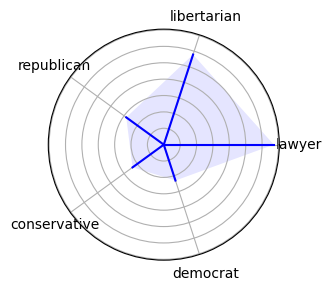


lawyer
No values available for the word. Finding the closest word in the dictionary...
The closest word in the dictionary for lawyer is legal.
{'value': 'Conformity', 'word': 'legal', 'similarity': 1.0, 'depth': 0}
{'value': 'Conformity', 'word': 'law', 'similarity': 0.6070972558282192, 'depth': 0}

libertarian
No values available for the word. Finding the closest word in the dictionary...
The closest word in the dictionary for libertarian is liberal.
{'value': 'Universalism', 'word': 'liberal', 'similarity': 1.0, 'depth': 0}
{'value': 'Conformity', 'word': 'conservative', 'similarity': 0.855169681509927, 'depth': 0}
{'value': 'Universalism', 'word': 'democrats', 'similarity': 0.6624991470620656, 'depth': 0}

republican
{'value': 'Universalism', 'word': 'democratic', 'similarity': 0.7375593422348615, 'depth': 0}
{'value': 'Universalism', 'word': 'democrats', 'similarity': 0.6799039818041741, 'depth': 0}

conservative
{'value': 'Conformity', 'word': 'conservative', 'similarity': 1.0, '

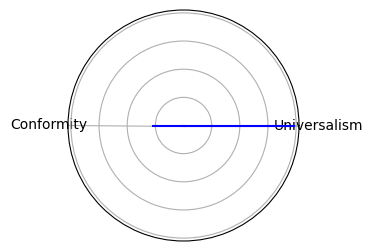

{'Universalism': 0.7815122332449214, 'Conformity': 0.2184877667550786}


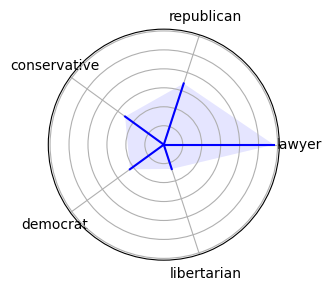


lawyer
No values available for the word. Finding the closest word in the dictionary...
The closest word in the dictionary for lawyer is legal.
{'value': 'Conformity', 'word': 'legal', 'similarity': 1.0, 'depth': 0}
{'value': 'Conformity', 'word': 'law', 'similarity': 0.6070972558282192, 'depth': 0}

republican
{'value': 'Universalism', 'word': 'democratic', 'similarity': 0.7375593422348615, 'depth': 0}
{'value': 'Universalism', 'word': 'democrats', 'similarity': 0.6799039818041741, 'depth': 0}

conservative
{'value': 'Conformity', 'word': 'conservative', 'similarity': 1.0, 'depth': 0}
{'value': 'Universalism', 'word': 'liberal', 'similarity': 0.8551696815099271, 'depth': 0}

democrat
{'value': 'Universalism', 'word': 'democrats', 'similarity': 0.7808641151188427, 'depth': 0}
{'value': 'Universalism', 'word': 'democratic', 'similarity': 0.7387792866411991, 'depth': 0}

libertarian
No values available for the word. Finding the closest word in the dictionary...
The closest word in the di

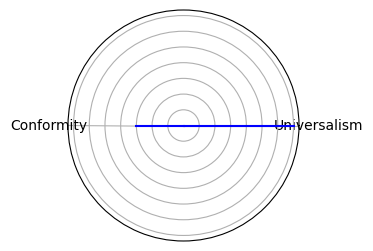

{'Universalism': 0.7002870868364247, 'Conformity': 0.29971291316357523}


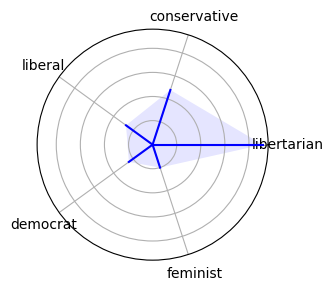


libertarian


KeyboardInterrupt: 

In [26]:
# Initialize an empty dictionary to store the human values for each argument ID
human_values_dict = {}

# Iterate over all arguments, stances, and conclusions
for argument, stance, conclusion, argument_id in zip(arguments, stances, conclusions, id):
    # Generate words using model
    generated_words = generate_word(stance, conclusion, argument, model_bert)

    # Plot the generated words
    radial_plot(generated_words[0])

    # Initialize an empty dictionary for aggregated values
    aggregated_values = {}

    # Detect human values for each generated word
    for word in generated_words[0].keys():
        aggregated_values = human_value_detection(word, value_map, similarity_model, aggregated_values)

    # Sort the aggregated values
    sorted_aggregated_values = sort_elements(aggregated_values)

    # Plot the sorted aggregated values
    radial_plot(sorted_aggregated_values)

    # Print the sorted aggregated values
    print(sorted_aggregated_values)

    # Store the sorted aggregated values in the dictionary
    human_values_dict[argument_id] = sorted_aggregated_values

In [27]:
transformed_dict = {k: list(v.keys()) for k, v in human_values_dict.items()}
print(transformed_dict)

{'A01001': ['Universalism', 'Conformity'], 'A01012': ['Universalism', 'Conformity']}


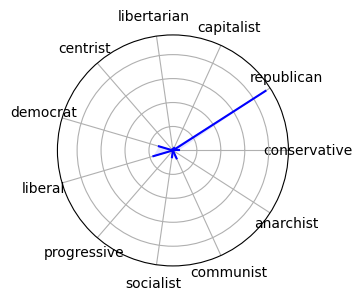


republican
{'value': 'Universalism', 'word': 'democratic', 'similarity': 0.7375593422348615, 'depth': 0}
{'value': 'Universalism', 'word': 'democrats', 'similarity': 0.6799039818041741, 'depth': 0}

liberal
{'value': 'Universalism', 'word': 'liberal', 'similarity': 1.0, 'depth': 0}
{'value': 'Conformity', 'word': 'conservative', 'similarity': 0.855169681509927, 'depth': 0}
{'value': 'Universalism', 'word': 'democrats', 'similarity': 0.6624991470620656, 'depth': 0}

democrat
{'value': 'Universalism', 'word': 'democrats', 'similarity': 0.7808641151188427, 'depth': 0}
{'value': 'Universalism', 'word': 'democratic', 'similarity': 0.7387792866411991, 'depth': 0}

communist
No values available for the word. Finding the closest word in the dictionary...
The closest word in the dictionary for communist is democratic.
{'value': 'Universalism', 'word': 'democratic', 'similarity': 1.0000000000000002, 'depth': 0}
{'value': 'Universalism', 'word': 'democrats', 'similarity': 0.7329228397345742, 'de

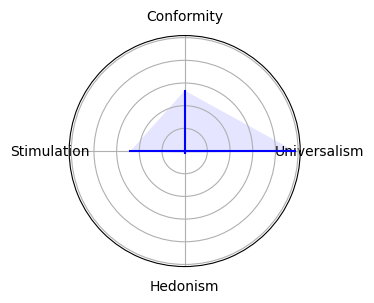

{'Universalism': 0.48502083877012236, 'Conformity': 0.2665916667918375, 'Stimulation': 0.23908859609982197, 'Hedonism': 0.009298898338218222}


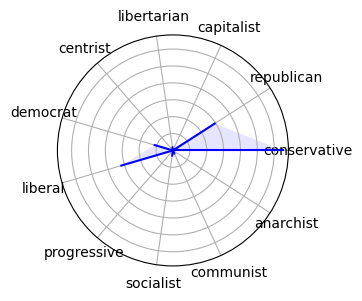


conservative
{'value': 'Conformity', 'word': 'conservative', 'similarity': 1.0, 'depth': 0}
{'value': 'Universalism', 'word': 'liberal', 'similarity': 0.8551696815099271, 'depth': 0}

liberal
{'value': 'Universalism', 'word': 'liberal', 'similarity': 1.0, 'depth': 0}
{'value': 'Conformity', 'word': 'conservative', 'similarity': 0.855169681509927, 'depth': 0}
{'value': 'Universalism', 'word': 'democrats', 'similarity': 0.6624991470620656, 'depth': 0}

republican
{'value': 'Universalism', 'word': 'democratic', 'similarity': 0.7375593422348615, 'depth': 0}
{'value': 'Universalism', 'word': 'democrats', 'similarity': 0.6799039818041741, 'depth': 0}

democrat
{'value': 'Universalism', 'word': 'democrats', 'similarity': 0.7808641151188427, 'depth': 0}
{'value': 'Universalism', 'word': 'democratic', 'similarity': 0.7387792866411991, 'depth': 0}

socialist
No values available for the word. Finding the closest word in the dictionary...
The closest word in the dictionary for socialist is libera

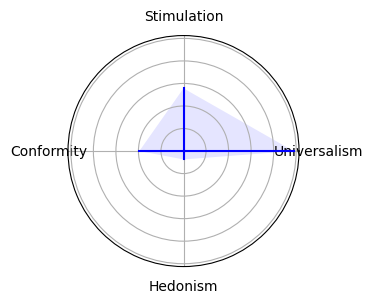

{'Universalism': 0.4882367812758684, 'Stimulation': 0.2785221490249555, 'Conformity': 0.19604547634630323, 'Hedonism': 0.03719559335287288}


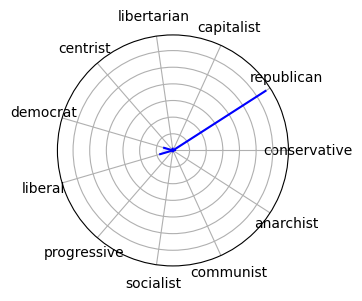


republican
{'value': 'Universalism', 'word': 'democratic', 'similarity': 0.7375593422348615, 'depth': 0}
{'value': 'Universalism', 'word': 'democrats', 'similarity': 0.6799039818041741, 'depth': 0}

liberal
{'value': 'Universalism', 'word': 'liberal', 'similarity': 1.0, 'depth': 0}
{'value': 'Conformity', 'word': 'conservative', 'similarity': 0.855169681509927, 'depth': 0}
{'value': 'Universalism', 'word': 'democrats', 'similarity': 0.6624991470620656, 'depth': 0}

democrat
{'value': 'Universalism', 'word': 'democrats', 'similarity': 0.7808641151188427, 'depth': 0}
{'value': 'Universalism', 'word': 'democratic', 'similarity': 0.7387792866411991, 'depth': 0}

conservative


KeyboardInterrupt: 

In [30]:
# Initialize an empty dictionary to store the human values for each argument ID
human_values_dict_guided = {}

# Iterate over all arguments, stances, and conclusions
for argument, stance, conclusion, argument_id in zip(arguments, stances, conclusions, id):
    # Generate words using model
    generated_words = generate_word_adj(stance, conclusion, argument, model, tokenizer, adjective_list)[1]
    
    # Plot the generated words
    radial_plot(generate_word_adj(stance, conclusion, argument, model, tokenizer, adjective_list)[0])
    
    # Initialize an empty dictionary for aggregated values
    aggregated_values_adj = {}

    # Detect human values for each generated word
    for word in generated_words.keys():
        aggregated_values_adj = human_value_detection(word, value_map, similarity_model, aggregated_values_adj)

    # Sort the aggregated values
    sorted_aggregated_values = sort_elements(aggregated_values_adj)
    
    # Plot the sorted aggregated values
    radial_plot(sorted_aggregated_values)

    # Print the sorted aggregated values
    print(sorted_aggregated_values)

    # Store the sorted aggregated values in the dictionary
    human_values_dict_guided[argument_id] = sorted_aggregated_values

In [31]:
transformed_dict_guided = {k: list(v.keys()) for k, v in human_values_dict_guided.items()}
print(transformed_dict_guided)

{'A01001': ['Universalism', 'Conformity', 'Stimulation', 'Hedonism'], 'A01012': ['Universalism', 'Stimulation', 'Conformity', 'Hedonism']}


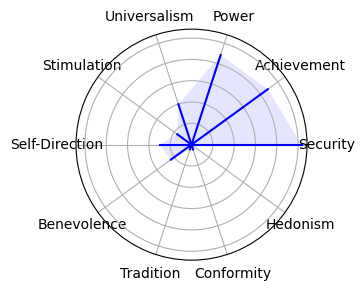

{'Security': 0.25800886290338637, 'Achievement': 0.221104436335202, 'Power': 0.221104436335202, 'Universalism': 0.09958906415212711, 'Stimulation': 0.04132380277297123, 'Self-Direction': 0.07471388320096803, 'Benevolence': 0.0597556414839543, 'Tradition': 0.011742652501150553, 'Conformity': 0.011760039970184726, 'Hedonism': 0.0008971803448536769}


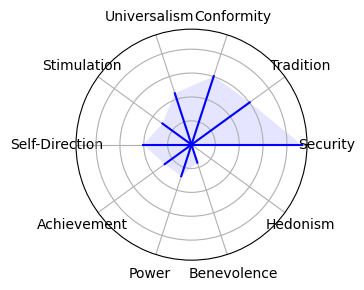

{'Security': 0.23048328760476314, 'Tradition': 0.15069901085395787, 'Conformity': 0.15087050824936155, 'Universalism': 0.11306321792450341, 'Stimulation': 0.07531754522491058, 'Self-Direction': 0.10119113391724167, 'Achievement': 0.06936761603229846, 'Power': 0.06936761603229846, 'Benevolence': 0.03943657563809126, 'Hedonism': 0.00020348852257357348}


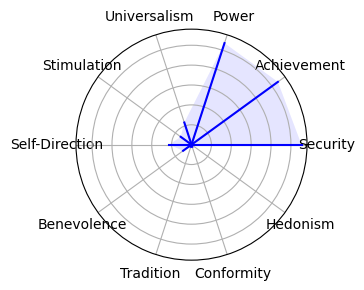

{'Security': 0.27664137375052095, 'Achievement': 0.2685601080752399, 'Power': 0.2685601080752399, 'Universalism': 0.05852261445529865, 'Stimulation': 0.03350561282870115, 'Self-Direction': 0.05616983819922632, 'Benevolence': 0.02615662485147978, 'Tradition': 0.005591823275727582, 'Conformity': 0.00563310896149857, 'Hedonism': 0.0006587875270672127}


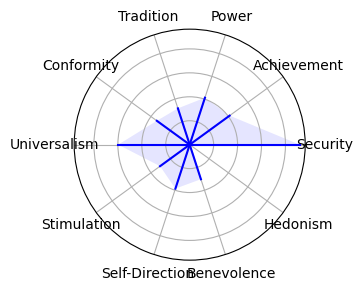

{'Security': 0.22974381113616432, 'Achievement': 0.10313891210625374, 'Power': 0.10313891210625374, 'Tradition': 0.07971705461254606, 'Conformity': 0.0848155876745063, 'Universalism': 0.14938307075641657, 'Stimulation': 0.07648082954326435, 'Self-Direction': 0.09659244095197898, 'Benevolence': 0.07589508525449898, 'Hedonism': 0.0010942958581169624}


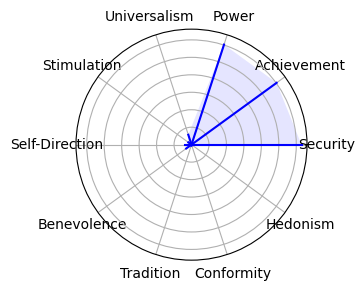

{'Security': 0.31498147310361574, 'Achievement': 0.3012671265750188, 'Power': 0.3012671265750188, 'Universalism': 0.029817703771564483, 'Stimulation': 0.011314521918328931, 'Self-Direction': 0.017973721742227573, 'Benevolence': 0.01893189900776647, 'Tradition': 0.002188569191276511, 'Conformity': 0.002197924319709156, 'Hedonism': 5.9933795473525534e-05}


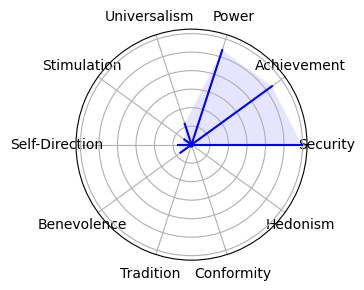

{'Security': 0.29726488519260613, 'Achievement': 0.2687417201398658, 'Power': 0.2687417201398658, 'Universalism': 0.059616445179273544, 'Stimulation': 0.023616644286080672, 'Self-Direction': 0.03570131296667719, 'Benevolence': 0.036581881175275464, 'Tradition': 0.004736277474506393, 'Conformity': 0.004760222906161414, 'Hedonism': 0.00023889053968759663}


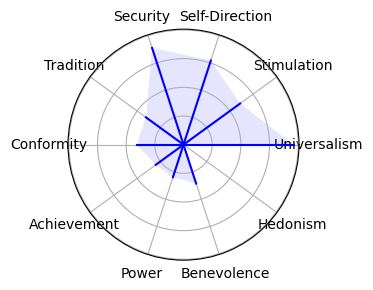

{'Universalism': 0.1918770558757407, 'Stimulation': 0.1220221055376038, 'Self-Direction': 0.154288811444046, 'Security': 0.17737055899142115, 'Tradition': 0.08096672952620244, 'Conformity': 0.08196012549568377, 'Achievement': 0.05971109478282693, 'Power': 0.05971109478282693, 'Benevolence': 0.07131397041508505, 'Hedonism': 0.0007784531485632739}


KeyboardInterrupt: 

In [32]:
human_values_dict_guidedValues = {}

for argument, stance, conclusion, argument_id in zip(arguments, stances, conclusions, id):
    desc_order = {}
    value_probs = {}
    
    for adj, prob in generate_word_adj(stance, conclusion, argument, model, tokenizer, adjective_list)[1].items():
        human_value = mapped_adjective_values.get(adj)
        if human_value is not None:
            human_value = [VALUE_LABELS.get(k) for k in human_value]
            if None not in human_value:
                desc_order[tuple(human_value)] = prob
                
    for values, prob in desc_order.items():
        for value in values:
            if value not in value_probs:
                value_probs[value] = 0
            value_probs[value] += prob
    
    total_prob = sum(value_probs.values())
    
    # Normalize
    normalized_probs = {k: v / total_prob for k, v in value_probs.items()}
    
    radial_plot(normalized_probs)
    print(normalized_probs)
    human_values_dict_guidedValues[argument_id] = normalized_probs

In [33]:
transformed_dict_guidedValues = {k: list(v.keys())[:3] for k, v in human_values_dict_guidedValues.items()}
print(transformed_dict_guidedValues)

{'A01001': ['Security', 'Achievement', 'Power'], 'A01012': ['Security', 'Tradition', 'Conformity'], 'A02001': ['Security', 'Achievement', 'Power'], 'A02002': ['Security', 'Achievement', 'Power'], 'A02009': ['Security', 'Achievement', 'Power'], 'A02018': ['Security', 'Achievement', 'Power'], 'A03005': ['Universalism', 'Stimulation', 'Self-Direction']}


In [145]:
# For this experiment, only 10 human values are taken into consideration
allowed_values = set(['Security', 'Conformity', 'Tradition', 'Benevolence', 'Universalism', 
                      'Self-direction', 'Stimulation', 'Hedonism', 'Achievement', 'Power'])

# Filtering the SemEval dict for avoiding the other values
filtered_dict = {key: [value for value in values if value in allowed_values] for key, values in semeval_validation_set_results.items()}

In [155]:
def calculate_average_metrics(predicted_dict, ground_truth_dict):
    total_f1 = 0
    total_accuracy = 0
    count = 0

    for key in ground_truth_dict.keys():
        if key in predicted_dict:
            # Converting human values to binary format for calculation, in a case insensitive way
            human_values = list(set([v.lower() for v in ground_truth_dict[key] + predicted_dict[key]]))
            y_true_binary = [1 if value in [v.lower() for v in ground_truth_dict[key]] else 0 for value in human_values]
            y_pred_binary = [1 if value in [v.lower() for v in predicted_dict[key]] else 0 for value in human_values]

            # Calculating F1 Score
            f1 = f1_score(y_true_binary, y_pred_binary, average='binary')

            # Calculating Accuracy
            accuracy = accuracy_score(y_true_binary, y_pred_binary)

            total_f1 += f1
            total_accuracy += accuracy
            count += 1

    # Calculating average F1 and Accuracy
    avg_f1 = total_f1 / count if count > 0 else 0
    avg_accuracy = total_accuracy / count if count > 0 else 0

    return avg_f1, avg_accuracy

In [110]:
f1_free, accuracy_free = calculate_average_metrics(transformed_dict, filtered_dict)
print(f"FREE APPROACH = F1 Score: {f1_free}, Accuracy: {accuracy_free}")

FREE APPROACH = F1 Score: 0.34220582218999757, Accuracy: 0.2306499480945675


In [111]:
f1_guided, accuracy_guided = calculate_average_metrics(transformed_dict_guided, filtered_dict)
print(f"GUIDED APPROACH - FREE MAPPING = F1 Score: {f1_guided}, Accuracy: {accuracy_guided}")

GUIDED APPROACH - FREE MAPPING = F1 Score: 0.25881620723392823, Accuracy: 0.16155063291139207


In [112]:
f1_guidedMapping, accuracy_guidedMapping = calculate_average_metrics(transformed_dict_guidedValues, filtered_dict)
print(f"GUIDED APPROACH - GUIDED MAPPING = F1 Score: {f1_guidedMapping}, Accuracy: {accuracy_guidedMapping}")

GUIDED APPROACH - GUIDED MAPPING = F1 Score: 0.3422260199950044, Accuracy: 0.23088875493938654


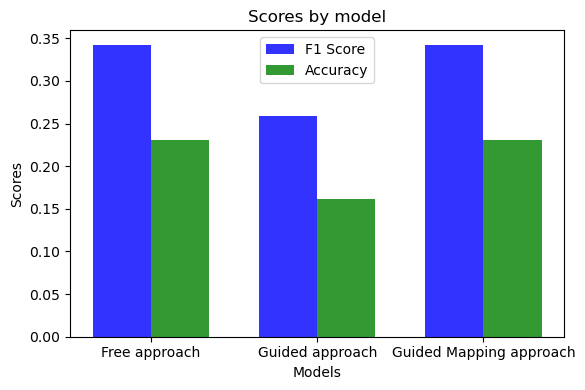

In [113]:
models = ['Free approach', 'Guided approach', 'Guided Mapping approach']
f1_scores = [f1_free, f1_guided, f1_guidedMapping]
accuracies = [accuracy_free, accuracy_guided, accuracy_guidedMapping]

# Getting the x locations for the groups
ind = np.arange(len(models)) 

fig, ax = plt.subplots(figsize=(6, 4))
bar_width = 0.35
opacity = 0.8

# Create the bars for F1 scores
rects1 = ax.bar(ind - bar_width/2, f1_scores, bar_width, alpha=opacity, color='b', label='F1 Score')

# Create the bars for accuracies
rects2 = ax.bar(ind + bar_width/2, accuracies, bar_width, alpha=opacity, color='g', label='Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Scores by model')
ax.set_xticks(ind)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()

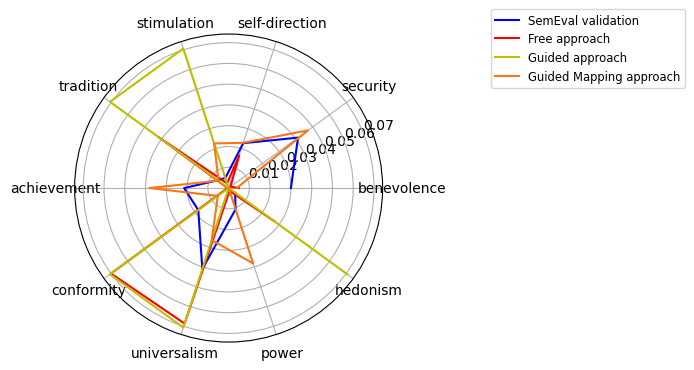

In [152]:
# Calculating number of occurrencies for each value in the dictionaries, in a case insensitive way
def count_predictions(dictionary):
    all_values = [value.lower() for values in dictionary.values() for value in values]
    return Counter(all_values)

counts_semeval = count_predictions(filtered_dict)
counts_transformed = count_predictions(transformed_dict)
counts_guided = count_predictions(transformed_dict_guided)
counts_guidedValues = count_predictions(transformed_dict_guidedValues)

# Creating a human values list
human_values = list(set(list(counts_semeval.keys()) + list(counts_transformed.keys()) + list(counts_guided.keys()) + list(counts_guidedValues.keys())))

# Counting list
counts = [counts_semeval, counts_transformed, counts_guided, counts_guidedValues]
data = [[count[value] for value in human_values] for count in counts]
# Normalization
total_predictions = sum([sum(count.values()) for count in counts])
data = [[count / total_predictions for count in dataset] for dataset in data]

# Radial plot
theta = np.linspace(0.0, 2 * np.pi, len(human_values), endpoint=False)
colors = ['b', 'r', 'y', '#fa7516']
labels = ['SemEval validation', 'Free approach', 'Guided approach', 'Guided Mapping approach']

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 4))

for i in range(len(data)):
    lines = ax.plot(theta, data[i], color=colors[i], label=labels[i])

ax.set_xticks(theta)
ax.set_xticklabels(human_values)
ax.yaxis.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(2, 1.1), fontsize='small')

plt.show()

In [180]:
def calculate_metrics_per_value(predicted_dict, ground_truth_dict):
    # Initialize a dictionary to store the metrics for each human value
    metrics = defaultdict(lambda: {'total_precision': 0, 'total_recall': 0, 'total_f1': 0, 'count': 0})
    # Iterate over each key in the ground truth dictionary
    for key in ground_truth_dict.keys():
        # Check if the key is also present in the predicted dictionary
        if key in predicted_dict:
            # Convert human values to binary format for calculation
            # All values are converted to lowercase to make the function case insensitive
            human_values = list(set([v.lower() for v in ground_truth_dict[key] + predicted_dict[key]]))
            y_true_binary = [1 if value in [v.lower() for v in ground_truth_dict[key]] else 0 for value in human_values]
            y_pred_binary = [1 if value in [v.lower() for v in predicted_dict[key]] else 0 for value in human_values]
            
            # Calculate Precision, Recall, and F1 Score for each human value
            precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
            recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
            f1 = f1_score(y_true_binary, y_pred_binary)

            # Update the metrics for each human value
            for i, value in enumerate(human_values):
                if y_true_binary[i] == 1 or y_pred_binary[i] == 1:
                    metrics[value]['total_precision'] += precision
                    metrics[value]['total_recall'] += recall
                    metrics[value]['total_f1'] += f1
                    metrics[value]['count'] += 1
    # Calculate average Precision, Recall, and F1 Score for each human value
    for value, data in metrics.items():
        avg_precision = data['total_precision'] / data['count'] if data['count'] > 0 else 0
        avg_recall = data['total_recall'] / data['count'] if data['count'] > 0 else 0
        avg_f1 = data['total_f1'] / data['count'] if data['count'] > 0 else 0
        metrics[value] = {'Average Precision': avg_precision, 'Average Recall': avg_recall, 'Average F1': avg_f1}
    # Sort the metrics by F1 score in descending order
    sorted_metrics = dict(sorted(metrics.items(), key=lambda item: item[1]['Average F1'], reverse=True))
    for value, metric in sorted_metrics.items():
      print(f"Human Value: {value}\n Average F1 Score: {metric['Average F1']}\n Average Precision: {metric['Average Precision']}\n Average Recall: {metric['Average Recall']}\n")
    
    return sorted_metrics

In [184]:
metrics_free = calculate_metrics_per_value(transformed_dict, filtered_dict)

Human Value: conformity
 Average F1 Score: 0.3432144626795031
 Average Precision: 0.3426124899112192
 Average Recall: 0.39433325766747473

Human Value: universalism
 Average F1 Score: 0.3428601162859415
 Average Precision: 0.34197032067896566
 Average Recall: 0.3942553488844854

Human Value: tradition
 Average F1 Score: 0.33275271145400837
 Average Precision: 0.30936714079571104
 Average Recall: 0.4021943929086779

Human Value: stimulation
 Average F1 Score: 0.3205269578403905
 Average Precision: 0.32462686567164184
 Average Recall: 0.3488569059464583

Human Value: hedonism
 Average F1 Score: 0.31713758833758926
 Average Precision: 0.2833428571428576
 Average Recall: 0.4025095238095236

Human Value: benevolence
 Average F1 Score: 0.31334984459984555
 Average Precision: 0.33668934240362786
 Average Recall: 0.3318069727891154

Human Value: security
 Average F1 Score: 0.304908286779369
 Average Precision: 0.32853092893379265
 Average Recall: 0.31472801295988323

Human Value: self-directio

In [185]:
metrics_guided = calculate_metrics_per_value(transformed_dict_guided, filtered_dict)

Human Value: stimulation
 Average F1 Score: 0.25881620723392823
 Average Precision: 0.21075949367088148
 Average Recall: 0.37397779787020347

Human Value: tradition
 Average F1 Score: 0.25881620723392823
 Average Precision: 0.21075949367088148
 Average Recall: 0.37397779787020347

Human Value: conformity
 Average F1 Score: 0.25881620723392823
 Average Precision: 0.21075949367088148
 Average Recall: 0.37397779787020347

Human Value: universalism
 Average F1 Score: 0.25881620723392823
 Average Precision: 0.21075949367088148
 Average Recall: 0.37397779787020347

Human Value: hedonism
 Average F1 Score: 0.25881620723392823
 Average Precision: 0.21075949367088148
 Average Recall: 0.37397779787020347

Human Value: security
 Average F1 Score: 0.23256389938085198
 Average Precision: 0.20018034265103563
 Average Recall: 0.29449525527072823

Human Value: benevolence
 Average F1 Score: 0.2323706659110395
 Average Precision: 0.20472049689441002
 Average Recall: 0.2805530908015385

Human Value: sel

In [186]:
metrics_guidedValues = calculate_metrics_per_value(transformed_dict_guidedValues, filtered_dict)

Human Value: power
 Average F1 Score: 0.3330431228285289
 Average Precision: 0.3396280400572234
 Average Recall: 0.35672593500919625

Human Value: security
 Average F1 Score: 0.33290473905577145
 Average Precision: 0.3412505075111635
 Average Recall: 0.3536374050229104

Human Value: universalism
 Average F1 Score: 0.3312575200928291
 Average Precision: 0.3432245301681479
 Average Recall: 0.35028878762187315

Human Value: achievement
 Average F1 Score: 0.3303333773944439
 Average Precision: 0.3394402035623393
 Average Recall: 0.35052435478007943

Human Value: stimulation
 Average F1 Score: 0.32432845325348975
 Average Precision: 0.3342762847713359
 Average Recall: 0.35450090927460126

Human Value: benevolence
 Average F1 Score: 0.3232727835365455
 Average Precision: 0.35282874617737053
 Average Recall: 0.3159089667977286

Human Value: self-direction
 Average F1 Score: 0.3092577002491201
 Average Precision: 0.32380044486812803
 Average Recall: 0.32636411094466383

Human Value: hedonism
 

In [187]:
def plot_results_byValues(metrics) :
    labels = list(metrics.keys())
    precision_vals = [metrics[l]['Average Precision'] for l in labels]
    recall_vals = [metrics[l]['Average Recall'] for l in labels]
    f1_vals = [metrics[l]['Average F1'] for l in labels]
    
    x = np.arange(len(labels))  
    width = 0.3  
    
    # Dictionary for mapping human values into number ids (from 1 to 10)
    human_values_dict = {human_value: i+1 for i, human_value in enumerate(metrics.keys())}
    # Dictionary for legend explaination
    legend_dict = {i: human_value for human_value, i in VALUE_LABELS.items()}
    # Substituting labels with numbers
    labels = [int(key) for key in VALUE_LABELS.keys()]
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, precision_vals, width, label='Precision')
    rects2 = ax.bar(x, recall_vals, width, label='Recall')
    rects3 = ax.bar(x + width, f1_vals, width, label='F1 Score')
    ax.set_ylabel('Scores')
    ax.set_title('Scores by Human Value')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend() 
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    fig.tight_layout()
    plt.show()
    print("Legend:")
    for num, human_value in legend_dict.items():
        print(f"{num}: {human_value}")

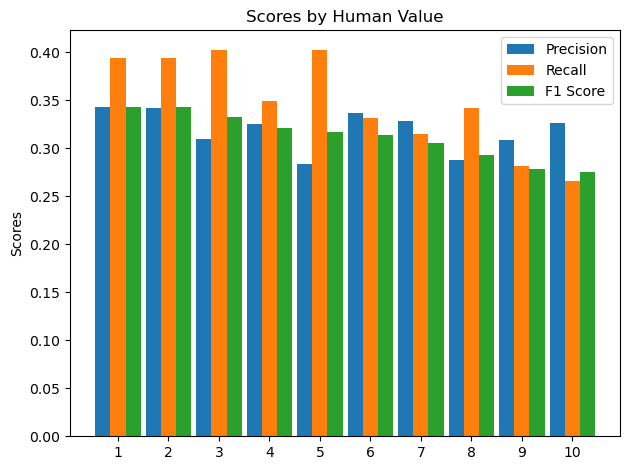

In [177]:
plot_results_byValues(metrics_free)

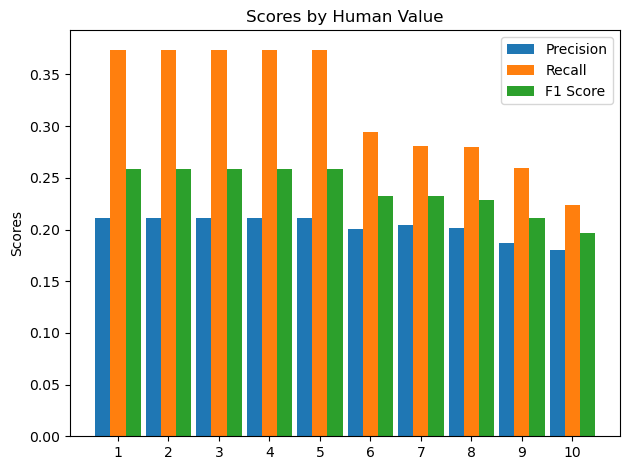

In [178]:
plot_results_byValues(metrics_guided)

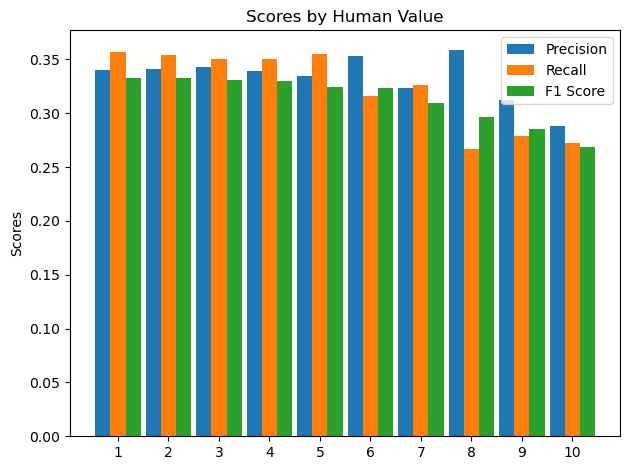

Legend:
Security: 1
Conformity: 2
Tradition: 3
Benevolence: 4
Universalism: 5
Self-Direction: 6
Stimulation: 7
Hedonism: 8
Achievement: 9
Power: 10


In [179]:
plot_results_byValues(metrics_guidedValues)